# 4.a Aumento de Datos y Despliegue

Hasta ahora, hemos seleccionado una arquitectura de modelo que mejora enormemente el rendimiento del modelo, ya que está diseñada para reconocer características importantes en las imágenes. La precisión de la validación sigue estando por detrás de la precisión del entrenamiento, lo que es un signo de sobreajuste: el modelo se confunde con cosas que no ha visto antes cuando se prueba con el conjunto de datos de validación.

Para enseñar a nuestro modelo a ser más robusto ante nuevos datos, vamos a aumentar mediante programación el tamaño y la varianza de nuestro conjunto de datos. Esto se conoce como [*aumento de datos*](https://link.springer.com/article/10.1186/s40537-019-0197-0), una técnica útil para muchas aplicaciones de aprendizaje profundo.

El aumento del tamaño proporciona al modelo más imágenes de las que aprender durante el entrenamiento. El aumento de la varianza ayuda al modelo a ignorar las características sin importancia y a seleccionar solo las características que son verdaderamente importantes en la clasificación, lo que le permite generalizar mejor.

## 4a.1 Objetivos

* Aumentar el conjunto de datos ASL
* Utilizar los datos aumentados para entrenar un modelo mejorado.
* Guarda el modelo bien entrenado en disco para utilizarlo en el despliegue.

In [48]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import kagglehub

import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [49]:
from utils import MyConvBlock

In [50]:
train_set = torchvision.datasets.MNIST("/content/", train=True, download=True)
valid_set = torchvision.datasets.MNIST("/content/", train=False, download=True)

In [51]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/
    Split: Train

## 4a.2 Preparación de los datos

Como estamos en un cuaderno nuevo, cargaremos y procesaremos nuestros datos de nuevo. Para ello, ejecuta la siguiente celda:

In [52]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv("/content/mnist_train.csv")
valid_df = pd.read_csv("/content/mnist_test.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

## 4a.3 Creación de modelos

También tendremos que volver a crear nuestro modelo. Como aprendimos en la última lección, las redes neuronales convolucionales utilizan una secuencia repetida de capas. Aprovechemos este patrón para crear nuestro propio [módulo personalizado](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html). Podemos entonces utilizar este módulo como una capa en nuestro modelo [Secuencial](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

Para ello, extenderemos la clase [Módulo](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Luego definiremos dos métodos:
* `__init__`: define cualquier propiedad que queramos que tenga nuestro módulo, incluyendo las capas de nuestra red neuronal. Efectivamente estaremos usando un modelo dentro de otro modelo.
* `forward`: define cómo queremos que el módulo procese los datos entrantes de la capa anterior a la que está conectado. Como estamos usando un modelo `Secuencial`, podemos pasarle los datos de entrada como si estuviéramos haciendo una predicción.

In [53]:
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

Ahora que hemos definido nuestro módulo personalizado, veámoslo en acción. El modelo de abajo es archecturialmente el mismo que en la lección anterior. ¿Puedes ver la conexión?

In [54]:
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

Cuando imprimamos el modelo, no sólo mostrará ahora el uso de nuestro módulo personalizado, sino que también mostrará las capas dentro de nuestro módulo personalizado:

In [55]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

model = torch.compile(base_model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affin

Los módulos personalizados son flexibles, y podemos definir cualquier otro método o propiedad que deseemos. Esto los hace potentes cuando los científicos de datos intentan resolver problemas complejos.

## 4a.4 Aumento de Datos

Antes de definir nuestro bucle de entrenamiento, es hora de configurar nuestro aumento de datos.

Hemos visto [TorchVision](https://pytorch.org/vision/stable/index.html)'s [Transforms](https://pytorch.org/vision/0.9/transforms.html) antes, pero en esta lección, exploraremos más a fondo sus herramientas de aumento de datos. En primer lugar, vamos a obtener una imagen de muestra para probar:

In [56]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

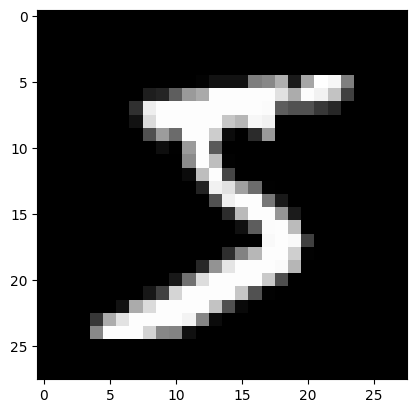

In [57]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

### 4a.4.1 [RandomResizeCrop](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomResizedCrop)

Esta transformación cambiará aleatoriamente el tamaño de la imagen de entrada basándose en `scale`, y luego la [recortará](https://en.wikipedia.org/wiki/Cropping_(image)) al tamaño que especifiquemos. En este caso, la recortaremos a las dimensiones de la imagen original. Para hacer esto, TorchVision necesita saber la [relación de aspecto](https://en.wikipedia.org/wiki/Aspect_ratio_(image)) de la imagen que está escalando. Como nuestra altura es la misma que nuestra anchura, nuestra `relación` de aspecto es 1:1.

In [58]:
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])

Pruebe a ejecutar la celda siguiente varias veces. Debería ser diferente cada vez.

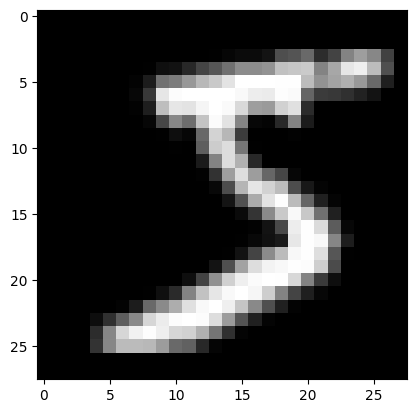

In [59]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [60]:
new_x_0.shape

torch.Size([1, 28, 28])

### 4a.4.2 [RandomHorizontalFlip](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip)

También podemos voltear aleatoriamente nuestras imágenes [Horizontalmente](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip) o [Verticalmente](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomVerticalFlip). Sin embargo, para estas imágenes, sólo las voltearemos horizontalmente.

Piensa un momento por qué querríamos voltear las imágenes horizontalmente, pero no verticalmente. Cuando tengas una idea, revela el texto de abajo.

`# SOLUCIÓN` Dato curioso: el lenguaje de signos americano puede hacerse con la mano izquierda o derecha dominante. Sin embargo, es poco probable ver el lenguaje de signos del revés. Este tipo de razonamiento específico del dominio puede ayudar a tomar buenas decisiones para tus propias aplicaciones de aprendizaje profundo.

In [61]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])

Intenta ejecutar la celda de abajo unas cuantas veces. ¿Se voltea la imagen la mitad de las veces?

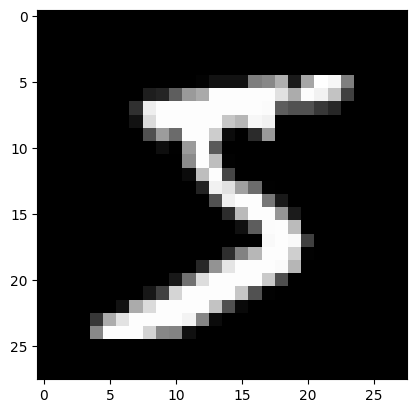

In [62]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4.3 [RandomRotation](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomRotation)

También podemos rotar aleatoriamente la imagen para añadir más variabilidad. Al igual que con otras técnicas de aumento, es fácil pasarse accidentalmente. Con ASL, si rotamos demasiado, nuestras «D» pueden parecer «G» y viceversa. Por eso, limitémoslo a 30 grados.

In [63]:
trans = transforms.Compose([
    transforms.RandomRotation(10)
])

Cuando ejecutamos el bloque de celdas de abajo, pueden aparecer algunos píxeles negros. Las esquinas o nuestra imagen desaparecen cuando giramos, y por casi cada píxel que perdemos, ganamos un píxel vacío.

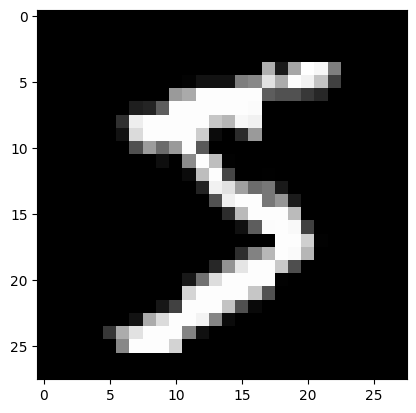

In [64]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4.3 [ColorJitter](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.ColorJitter)

La transformación `ColorJitter` tiene 4 argumentos:
* [brillo](https://en.wikipedia.org/wiki/Brightness)
* [contraste](https://en.wikipedia.org/wiki/Contrast_(vision))
* [saturación](https://en.wikipedia.org/wiki/Colorfulness#Saturation)
* [tono](https://en.wikipedia.org/wiki/Hue)


Los 2 últimos se aplican a las imágenes en color, así que por ahora sólo utilizaremos los 2 primeros.

In [65]:
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])

Pruebe a ejecutar lo siguiente varias veces, pero también pruebe a cambiar el `brillo` o el `contraste` a `1` en la celda anterior. ¿Obtiene algún resultado interesante?

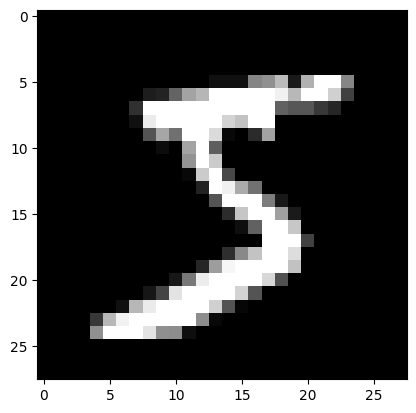

In [66]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.3.4 [Compose](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose)

Es hora de unirlo todo. Podemos crear una secuencia de estas transformaciones aleatorias con `Compose`.

In [67]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

Hagamos la prueba. Con todas las combinaciones diferentes, ¿cuántas variaciones hay de esta imagen? ¿Infinitas?

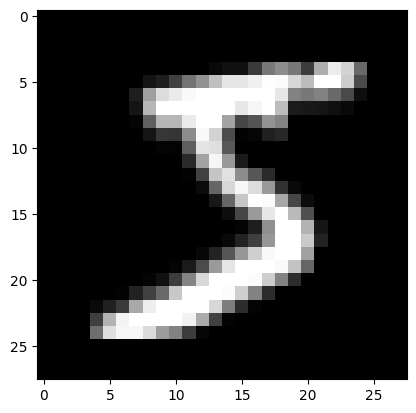

In [68]:
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4 Entrenamiento con Data Augmentation

Nuestro entrenamiento es en su mayor parte el mismo, pero hay una línea de cambio. Antes de pasar nuestras imágenes a nuestro modelo, aplicaremos nuestras `random_transforms`. Por conveniencia, hemos movido `get_batch_accuracy` a un archivo `utils`.

In [69]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))  # Updated
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += utils.get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

En el otro lado, la validación sigue siendo la misma. No hay transformaciones aleatorias.

In [70]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += utils.get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

Pongamos a prueba el aumento de datos.

In [71]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 408.3365 Accuracy: 0.9304
Valid - Loss: 31.1498 Accuracy: 0.9691
Epoch: 1
Train - Loss: 163.8213 Accuracy: 0.9725
Valid - Loss: 77.8916 Accuracy: 0.9238
Epoch: 2
Train - Loss: 132.9798 Accuracy: 0.9784
Valid - Loss: 39.5830 Accuracy: 0.9586
Epoch: 3
Train - Loss: 109.5627 Accuracy: 0.9821
Valid - Loss: 19.1959 Accuracy: 0.9799
Epoch: 4
Train - Loss: 96.9499 Accuracy: 0.9840
Valid - Loss: 25.9771 Accuracy: 0.9748
Epoch: 5
Train - Loss: 89.6839 Accuracy: 0.9853
Valid - Loss: 10.9177 Accuracy: 0.9885
Epoch: 6
Train - Loss: 81.2022 Accuracy: 0.9868
Valid - Loss: 36.9799 Accuracy: 0.9613
Epoch: 7
Train - Loss: 78.3044 Accuracy: 0.9873
Valid - Loss: 16.1134 Accuracy: 0.9832
Epoch: 8
Train - Loss: 70.2516 Accuracy: 0.9887
Valid - Loss: 17.3115 Accuracy: 0.9833
Epoch: 9
Train - Loss: 67.9855 Accuracy: 0.9886
Valid - Loss: 35.4569 Accuracy: 0.9631
Epoch: 10
Train - Loss: 64.6247 Accuracy: 0.9890
Valid - Loss: 26.7536 Accuracy: 0.9737
Epoch: 11
Train - Loss: 59.6015 Accura

## Discusión de resultados

Observará que la precisión de la validación es mayor y más coherente. Esto significa que nuestro modelo ya no se sobreajusta como antes; generaliza mejor, haciendo mejores predicciones con nuevos datos.

La precisión del entrenamiento puede ser menor, y no pasa nada. En comparación con antes, el modelo está expuesto a una variedad mucho mayor de datos.

## Guardar el modelo

Ahora que tenemos un modelo bien entrenado, querremos desplegarlo para realizar inferencias sobre nuevas imágenes.

Es común, una vez que tenemos un modelo entrenado con el que estamos contentos, guardarlo en el disco. PyTorch tiene [múltiples maneras](https://pytorch.org/tutorials/beginner/saving_loading_models.html) para hacer esto, pero por ahora, vamos a utilizar `torch.save`. También necesitaremos guardar el código para nuestro módulo personalizado `MyConvBlock`, lo que hicimos en [utils.py](./utils.py). En el siguiente cuaderno, cargaremos el modelo y lo usaremos para leer nuevas imágenes del lenguaje de signos.

PyTorch no puede guardar un modelo compilado ([ver este post](https://discuss.pytorch.org/t/how-to-save-load-a-model-with-torch-compile/179739)), así que en su lugar haremos lo siguiente

In [72]:
torch.save(base_model, 'model.pth')

## Descarga el archivo model.pth, lo usarás para el laboratorio 4.b

# Preguntas

1. ¿Qué es el aumento de datos y por qué es importante en el aprendizaje profundo?

2. Describe el papel de las capas convolucionales en una red neuronal.

3. ¿Cuál es la diferencia entre la precisión de entrenamiento y la precisión de validación en un modelo de aprendizaje profundo?

4. ¿Cómo afectan las transformaciones aleatorias como RandomHorizontalFlip y RandomRotation a la robustez del modelo?

5. Da un ejemplo de cuándo una transformación podría no ser adecuada para ciertos tipos de datos.
